# A Look at Wildlife Diseases in Utah

This notebook analyses wildlife disease data from Utah DWR captures in the 2021-2022 fall/winter capture season. Please see [the github repo](https://github.com/epistemetrica/utah_dwr_python) for more info. 

## Project Description

Each observation in our dataset includes big game animal species, capture date and location, sex, pregnancy status, and the results of various disease-related lab tests.

### Key tasks:
1. Prepare the data for analysis 
2. Explore and visualize the dataset
3. Analyze the data to understand:
    - the prevelance of key diseases among wildlife in Utah
    - whether this data allows us to accurately predict disease states for new captures




In [42]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

%matplotlib inline 

## Data Processing

Lab results and DWR capture data were loaded into a SQLite db via the wildlife_ETL.py pipeline. 

In [2]:
#load db
engine = create_engine('sqlite:///data/wildlife.db')

#load dfs
bison_df = pd.read_sql_table(con=engine, table_name='bison_table')
deer_df = pd.read_sql_table(con=engine, table_name='deer_table')
elk_df = pd.read_sql_table(con=engine, table_name='elk_table')
moose_df = pd.read_sql_table(con=engine, table_name='moose_table')
pronghorn_df = pd.read_sql_table(con=engine, table_name='pronghorn_table')
sheep_goat_df = pd.read_sql_table(con=engine, table_name='sheep_goat_table')

Let's take a look at the data:

In [3]:
display(bison_df.head())
bison_df.info()

,sample_id,archive_id,species,sex,capture_date,capture_unit,bvd_type1_result,bvd_type2_result,ehdv_result,preg_val,preg_result,bluetongue_result
0,BCB1101,BIS21-018,Bison,Female,2022-02-27,Book Cliffs,Negative,Negative,Positive,0.091,Not pregnant,Detected
1,BCB1102,BIS21-019,Bison,Female,2022-02-26,Book Cliffs,Negative,Negative,Negative,0.749,Pregnant,Not detected
2,BCB1103,BIS21-020,Bison,Female,2022-02-27,Book Cliffs,Negative,Negative,Negative,0.091,Not pregnant,Not detected
3,BCB1104,BIS21-021,Bison,Female,2022-02-26,Book Cliffs,Negative,Negative,Negative,0.718,Pregnant,Not detected
4,BCB1105,BIS21-022,Bison,Male,2022-02-26,Book Cliffs,Negative,Negative,Negative,0.089,Not pregnant,Not detected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          35 non-null     object        
 1   archive_id         15 non-null     object        
 2   species            33 non-null     object        
 3   sex                33 non-null     object        
 4   capture_date       33 non-null     datetime64[ns]
 5   capture_unit       33 non-null     object        
 6   bvd_type1_result   34 non-null     object        
 7   bvd_type2_result   34 non-null     object        
 8   ehdv_result        34 non-null     object        
 9   preg_val           34 non-null     float64       
 10  preg_result        34 non-null     object        
 11  bluetongue_result  34 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 3.4+ KB


In [4]:
display(deer_df.head())
deer_df.info()

,sample_id,collar_id,species,sex,capture_date,capture_unit,adenovirus_result,ehdv_result,bluetongue_result
0,BC1101,50713.0,Mule Deer,Female,2021-12-11,Book Cliffs,>=1:4096,Negative,Not detected
1,BC1102,50716.0,Mule Deer,Female,2021-12-11,Book Cliffs,1:16,Negative,Not detected
2,BC1103,50714.0,Mule Deer,Female,2021-12-11,Book Cliffs,1:8,Positive,Detected
3,BC1104,50720.0,Mule Deer,Female,2021-12-11,Book Cliffs,>=1:4096,Negative,Not detected
4,BC1105,50722.0,Mule Deer,Male,2021-12-11,Book Cliffs,>=1:4096,Negative,Not detected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          339 non-null    object        
 1   collar_id          333 non-null    float64       
 2   species            333 non-null    object        
 3   sex                333 non-null    object        
 4   capture_date       333 non-null    datetime64[ns]
 5   capture_unit       333 non-null    object        
 6   adenovirus_result  336 non-null    object        
 7   ehdv_result        336 non-null    object        
 8   bluetongue_result  335 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 24.0+ KB


In [5]:
display(elk_df.head())
elk_df.info()

,sample_id,archive_id,collar_id,species,sex,capture_date,capture_unit,staging_area,age,comments,ehdv_type1_result,ehdv_type1_val,ehdv_type2_result,ehdv_type2_val,ehdv_type6_result,ehdv_type6_val,bvd_result,preg_val,preg_result,bluetongue_result
0,BCE1132,EL21-137,51628.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,23.5,None,Negative,<20,Positve,>1280,Negative,<20,Negative,0.660,Pregnant,Detected
1,BCE1134,EL21-138,46687.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,19.5,None,Negative,<20,Negative,<20,Negative,<20,Negative,0.649,Pregnant,Detected
2,BCE1135,EL21-139,46752.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,10.5,None,Negative,<20,Positive,40,Negative,<20,Negative,0.087,Open,Not detected
3,BCE1136,EL21-140,51622.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,13.5,None,Negative,<20,Negative,<20,Negative,<20,Negative,0.621,Pregnant,Not detected
4,BCE1138,EL21-141,46700.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,22.5,None,Negative,<20,Negative,<20,Negative,<20,Negative,0.612,Pregnant,Not detected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          148 non-null    object        
 1   archive_id         45 non-null     object        
 2   collar_id          146 non-null    float64       
 3   species            146 non-null    object        
 4   sex                146 non-null    object        
 5   capture_date       146 non-null    datetime64[ns]
 6   capture_unit       146 non-null    object        
 7   staging_area       136 non-null    object        
 8   age                145 non-null    float64       
 9   comments           9 non-null      object        
 10  ehdv_type1_result  145 non-null    object        
 11  ehdv_type1_val     145 non-null    object        
 12  ehdv_type2_result  145 non-null    object        
 13  ehdv_type2_val     145 non-null    object        
 14  ehdv_type6

In [6]:
display(moose_df.head())
moose_df.info()

,sample_id,collar_id,species,sex,capture_date,capture_unit,staging_area,preg_val,preg_result,bluetongue_result
0,PAR1111,50888,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,0.105,Open,Not detected
1,PAR1112,50891,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,1.165,Pregnant,Not detected
2,PAR1113,50892,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,1.180,Pregnant,Not detected
3,PAR1114,50890,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,1.202,Pregnant,Not detected
4,PAR1115,50889,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,1.177,Pregnant,Not detected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          5 non-null      object        
 1   collar_id          5 non-null      int64         
 2   species            5 non-null      object        
 3   sex                5 non-null      object        
 4   capture_date       5 non-null      datetime64[ns]
 5   capture_unit       5 non-null      object        
 6   staging_area       5 non-null      object        
 7   preg_val           5 non-null      float64       
 8   preg_result        5 non-null      object        
 9   bluetongue_result  5 non-null      object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 532.0+ bytes


In [7]:
display(pronghorn_df.head())
pronghorn_df.info()

,sample_id,archive_id,collar_id,species,sex,capture_date,capture_unit,staging_area,bluetongue_result
0,BCP1101,PH21-001,50770.0,Pronghorn,Female,2021-12-01,Book Cliffs,Danish Flat,Detected
1,BCP1102,PH21-002,50776.0,Pronghorn,Female,2021-12-01,Book Cliffs,Danish Flat,None
2,BCP1103,PH21-003,50769.0,Pronghorn,Female,2021-12-01,Book Cliffs,Danish Flat,Detected
3,BCP1104,PH21-015,50768.0,Pronghorn,Male,2021-12-01,Book Cliffs,Danish Flat,Detected
4,BCP1105,PH21-004,50774.0,Pronghorn,Female,2021-12-01,Book Cliffs,Danish Flat,Detected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          113 non-null    object        
 1   archive_id         15 non-null     object        
 2   collar_id          83 non-null     float64       
 3   species            108 non-null    object        
 4   sex                83 non-null     object        
 5   capture_date       108 non-null    datetime64[ns]
 6   capture_unit       108 non-null    object        
 7   staging_area       50 non-null     object        
 8   bluetongue_result  110 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 8.1+ KB


In [8]:
display(sheep_goat_df.head())
sheep_goat_df.info()

,sample_id,collar_id,species,sex,capture_date,capture_unit,staging_area,comments,movi_elisa_val,movi_elisa_result,movi_pcr_result,lentivirus_val,lentivirus_result,ehdv_val,ehdv_result,bluetongue_result,leukotoxin_lktA_result,tonsular_culture_result,tonsular_culture_isolate
0,SRS1101,50750.0,Bighorn Sheep,Female,2021-12-03,North San Rafael,Swinging Bridge,2 tonsillar swabs and 2 nasal swabs (SRS1101),80.903,Detected,Not detected,1.366,Negative,103.562,Negative,Negative,Not detected,No Pasteurella isolated.,None
1,SRS1102,50744.0,Bighorn Sheep,Female,2021-12-04,North San Rafael,Swinging Bridge,2 tonsillar swabs and 2 nasal swabs (SRS1102),61.281,Detected,Not detected,0.936,Negative,39.983,Indeterminate,Positive,Not detected,No Pasteurella isolated.,None
2,SRS1103,50749.0,Bighorn Sheep,Female,2021-12-03,North San Rafael,Swinging Bridge,"Short blood, veins flat, worried about heat. 2...",90.380,Detected,Detected,3.908,Negative,65.718,Negative,Positive,Not detected,No Pasteurella isolated.,None
3,SRS1104,50758.0,Bighorn Sheep,Female,2021-12-04,North San Rafael,Swinging Bridge,2 tonsillar swabs and 2 nasal swabs (SRS1104),72.088,Detected,None,2.541,Negative,61.098,Negative,Positive,None,None,None
4,SRS1105,50752.0,Bighorn Sheep,Female,2021-12-03,North San Rafael,Swinging Bridge,"Recapture. Old collar: 75535, 148.307. 2 tonsi...",74.081,Detected,Not detected,5.923,Negative,78.161,Negative,Negative,Not detected,No Pasteurella isolated.,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   sample_id                 71 non-null     object        
 1   collar_id                 57 non-null     float64       
 2   species                   62 non-null     object        
 3   sex                       58 non-null     object        
 4   capture_date              60 non-null     datetime64[ns]
 5   capture_unit              60 non-null     object        
 6   staging_area              10 non-null     object        
 7   comments                  16 non-null     object        
 8   movi_elisa_val            71 non-null     float64       
 9   movi_elisa_result         71 non-null     object        
 10  movi_pcr_result           59 non-null     object        
 11  lentivirus_val            71 non-null     float64       
 12  lentivirus_result       

In [9]:
#concat dfs
species_dfs = [bison_df, deer_df, elk_df, pronghorn_df, sheep_goat_df]
df = pd.concat(species_dfs)


### Drop unnecessary columns and rows

Many of the lab results in the database are not relevant to this project. For example, if the animal is pregnant, the exact value of the pregnancy test does not matter here. And as noted in the *definitions.md* file, columns like 'archive_id' are not useful for this project. 

There are also a handful of entries that do not have any associated lab results, as noted by the DWR Office's comments in the original spreadsheets. These rows are dropped. 

In [10]:
#drop columns not relevant to this project
df = df.drop(columns=['archive_id', 'preg_val', 'collar_id', 'ehdv_type1_val', 'ehdv_type2_val', 'ehdv_type6_val', 'movi_elisa_val', 'lentivirus_val', 'ehdv_val', 'tonsular_culture_isolate'])

#drop known duplicates and animals with missing samples.
comments_to_drop = ['*Double number, one sample', '*No record', '*missing sample']
df = df.drop(df[df.comments.isin(comments_to_drop)].index)

As a means of inspecting the data, let's look at the various values contained within each column:

In [11]:
for col in df.columns:
    print('The {} column has the following value counts: \n {} \n'.format(col, df[col].value_counts()))

The sample_id column has the following value counts: 
 sample_id
WM1101      2
UG1121      2
WM1104      2
WM1105      2
WM1106      2
           ..
OS1103      1
OS1104      1
OS1105      1
OS1106      1
BH21-010    1
Name: count, Length: 673, dtype: int64 

The species column has the following value counts: 
 species
Mule Deer        326
Elk              141
Pronghorn        104
Mt Goat           47
Bison             32
Bighorn Sheep     13
Name: count, dtype: int64 

The sex column has the following value counts: 
 sex
Female    555
Male       79
Name: count, dtype: int64 

The capture_date column has the following value counts: 
 capture_date
2022-02-06    31
2021-12-20    31
2021-12-11    30
2021-12-10    30
2021-12-18    29
2021-12-01    29
2022-02-05    26
2022-02-24    25
2022-02-28    25
2021-11-23    24
2021-12-12    24
2021-12-13    24
2021-12-05    24
2021-11-29    24
2021-12-16    23
2021-11-30    23
2021-12-14    20
2021-11-21    19
2021-11-22    18
2022-02-27    16
2021-

Two things jump out: 
1. There should not be more than one instance of any given sample_id. 
    - Repeated sample_ids appear in the original data provided by the DWR; the reasons for this duplication are under investigation. For now, I will drop the duplicated ids.
2. The columns that report bovine viral diarrhea and lentivirus are entirely negative, meaning those diseases are abscent from the database. We can drop those columns entirely. 

In [12]:
#drop duplicate sample_ids
#df = df.drop_duplicates(subset='sample_id')

#drop variables with all-negative results
df = df.drop(columns=['bvd_type1_result', 'bvd_type2_result', 'bvd_result', 'lentivirus_result'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 684 entries, 0 to 70
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   sample_id                684 non-null    object        
 1   species                  663 non-null    object        
 2   sex                      634 non-null    object        
 3   capture_date             661 non-null    datetime64[ns]
 4   capture_unit             661 non-null    object        
 5   ehdv_result              430 non-null    object        
 6   preg_result              170 non-null    object        
 7   bluetongue_result        672 non-null    object        
 8   adenovirus_result        329 non-null    object        
 9   staging_area             189 non-null    object        
 10  age                      140 non-null    float64       
 11  comments                 18 non-null     object        
 12  ehdv_type1_result        140 non-null    o

### Data Types

Before addressing the structural concerns, let's clean up the data types. To ease analysis later on, variables are encoded as binary values wherever possible (e.g., 'sex' with values of 'Female' and 'Male' becomes 'female' with values of 1 or 0). 

In [14]:
#encode sex as boolean 'female'
df['female'] = df.sex.apply(lambda row: 1 if row == 'Female' else 0)
del df['sex']

#set test results to 1/0, preserving NaN values
df.ehdv_result = df.ehdv_result.apply(lambda row: 1 if row in ['POSITIVE', 'Weak Positive', 'Positive'] else np.NaN if pd.isna(row) else 0)
df.preg_result = df.preg_result.apply(lambda row: 1 if row == 'Pregnant' else np.NaN if pd.isna(row) else 0)
df.bluetongue_result = df.bluetongue_result.apply(lambda row: 1 if row in ['Detected', 'Positive'] else np.NaN if pd.isna(row) else 0)
df.ehdv_type1_result = df.ehdv_type1_result.apply(lambda row: 1 if row == 'Positive' else np.NaN if pd.isna(row) else 0)
df.ehdv_type2_result = df.ehdv_type2_result.apply(lambda row: 1 if row in ['Positive', 'Positve'] else np.NaN if pd.isna(row) else 0)
df.ehdv_type6_result = df.ehdv_type6_result.apply(lambda row: 1 if row == 'Positive' else np.NaN if pd.isna(row) else 0)
df.movi_elisa_result = df.movi_elisa_result.apply(lambda row: 1 if row == 'Detected' else np.NaN if pd.isna(row) else 0)
df.movi_pcr_result = df.movi_pcr_result.apply(lambda row: 1 if row == 'Detected' else np.NaN if pd.isna(row) else 0)
df.leukotoxin_lktA_result = df.leukotoxin_lktA_result.apply(lambda row: 1 if row == 'Detected' else np.NaN if pd.isna(row) else 0)
#df.tonsular_culture_result - waiting on info from vet 


### Duplicates


In [15]:
df[df.duplicated(subset='sample_id', keep=False) == True]

##these currently correspond to the duplicate sample_ids in the master list of samples provided by DWR - waiting on further info from vet

,sample_id,species,capture_date,capture_unit,ehdv_result,preg_result,bluetongue_result,adenovirus_result,staging_area,age,comments,ehdv_type1_result,ehdv_type2_result,ehdv_type6_result,movi_elisa_result,movi_pcr_result,leukotoxin_lktA_result,tonsular_culture_result,female
309,WM1101,Mule Deer,2021-12-11,Wasatch-Manti,0.0,NaN,0.0,>=1:4096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
310,WM1101,Mule Deer,2021-12-05,Manti,0.0,NaN,0.0,>=1:4096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
311,WM1102,Mule Deer,2021-12-11,Wasatch-Manti,0.0,NaN,0.0,>=1:4096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
312,WM1102,Mule Deer,2021-12-05,Manti,0.0,NaN,0.0,>=1:4096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
313,WM1103,Mule Deer,2021-12-11,Wasatch-Manti,0.0,NaN,0.0,1:512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
314,WM1103,Mule Deer,2021-12-05,Manti,0.0,NaN,0.0,1:512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
315,WM1104,Mule Deer,2021-12-05,Manti,0.0,NaN,0.0,1:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
316,WM1104,Mule Deer,2021-12-11,Wasatch-Manti,0.0,NaN,0.0,1:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
317,WM1105,Mule Deer,2021-12-05,Manti,0.0,NaN,0.0,>=1:4096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
318,WM1105,Mule Deer,2021-12-11,Wasatch-Manti,0.0,NaN,0.0,>=1:4096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


## Exploratory Analysis

Now that our data is even tidy-er, we can start looking around in a more meaningful way. 

### Pregnancy 

Pregnancy tests were performed for elk and bison. 

In [33]:
#create df showing pregnancy result for tested female animals ## NOTE all bison were reported by the lab as "Pregnant" or "Not Pregnant"
preggers_df = df[df.preg_result.notna() & df.female == 1]
preggers_df.describe()

,capture_date,ehdv_result,preg_result,bluetongue_result,age,ehdv_type1_result,ehdv_type2_result,ehdv_type6_result,movi_elisa_result,movi_pcr_result,leukotoxin_lktA_result,female
count,159,22.000000,159.000000,156.000000,136.000000,137.000000,137.000000,137.000000,0.0,0.0,0.0,159.0
mean,2022-02-03 20:13:35.094339584,0.454545,0.823899,0.288462,9.455882,0.116788,0.255474,0.014599,NaN,NaN,NaN,1.0
min,2021-11-22 00:00:00,0.000000,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.0
25%,2022-02-05 00:00:00,0.000000,1.000000,0.000000,4.500000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.0
50%,2022-02-06 00:00:00,0.000000,1.000000,0.000000,7.500000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.0
75%,2022-02-27 00:00:00,1.000000,1.000000,1.000000,13.500000,0.000000,1.000000,0.000000,NaN,NaN,NaN,1.0
max,2022-03-07 00:00:00,1.000000,1.000000,1.000000,26.500000,1.000000,1.000000,1.000000,NaN,NaN,NaN,1.0
std,NaN,0.509647,0.382109,0.454506,6.427796,0.322346,0.437728,0.120379,NaN,NaN,NaN,0.0


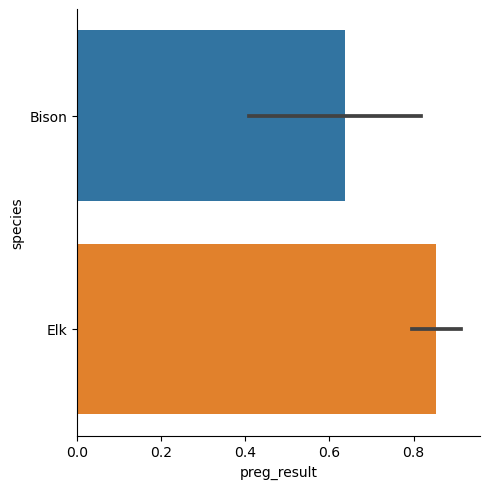

In [46]:
sns.catplot(preggers_df, x='preg_result', y='species', kind='bar')


## ML Modeling

Jumping ahead in the process, I want to see about predicting test results given the available data. Since bluetongue is the only test done on all species, I'll simplify to look at that disease. 

In [ ]:
#make df
bluetongue_df = df[['sample_id', 'species', 'sex', 'capture_date', 'capture_unit', 'bluetongue_result']].set_index('sample_id')

#drop date
bluetongue_df = bluetongue_df.drop(columns='capture_date')

#drop missing values
bluetongue_df = bluetongue_df.dropna()

In [ ]:
bluetongue_df = pd.get_dummies(bluetongue_df, columns=['species', 'sex', 'capture_unit'], drop_first=True)

In [ ]:
#split into X,y
X, y = bluetongue_df.drop(columns=['bluetongue_result']), bluetongue_df.bluetongue_result

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

#instantiate
model = LogisticRegression()

#fit
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)


In [ ]:
print(classification_report(y_test, y_pred))